<a href="https://colab.research.google.com/github/dTenebrae/pytorch_start/blob/main/HW_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты

In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from time import time

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

In [5]:
BATCH_SIZE = 128
EPOCHS = 300

In [6]:
train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                              train=True,  
                                              transform=torchvision.transforms.ToTensor(), 
                                              download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [7]:
test_dataset = torchvision.datasets.CIFAR100(root='./data', 
                                             train=False,
                                             download=True, 
                                             transform=torchvision.transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Files already downloaded and verified


In [8]:
image, label = train_dataset[0]
classes = train_dataset.classes

Class: cattle


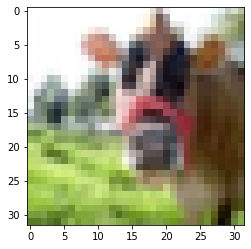

In [9]:
plt.imshow(image.permute(1, 2, 0).numpy());
print(f'Class: {classes[label]}')

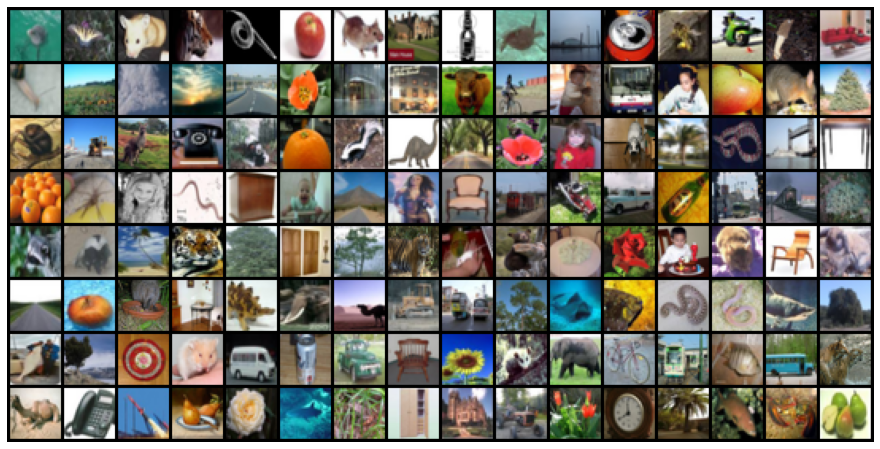

In [10]:
for images, _ in train_loader: 
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [11]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои 
# (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

In [12]:
def custom_lrelu(input, thr=0.5, n_slope=0.1):
    output = F.leaky_relu(thr * input, n_slope)
    return output
    
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 5 * hidden_dim)
        self.fc2 = nn.Linear(5 * hidden_dim, 4 * hidden_dim)
        self.fc3 = nn.Linear(4 * hidden_dim, 3 * hidden_dim)
        self.fc4 = nn.Linear(3 * hidden_dim, 2 * hidden_dim)
        self.fc5 = nn.Linear(2 * hidden_dim, output_dim)

    
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = custom_lrelu(x)
        x = self.fc2(x)
        x = custom_lrelu(x)
        x = self.fc3(x)
        x = custom_lrelu(x)
        x = self.fc4(x)
        x = custom_lrelu(x)
        x = self.fc5(x)
        return x
    
    def predict(self, x):
        x = x.reshape(x.shape[0], -1)
        
        x = self.fc1(x)
        x = custom_lrelu(x)
        x = self.fc2(x)
        x = custom_lrelu(x)
        x = self.fc3(x)
        x = custom_lrelu(x)
        x = self.fc4(x)
        x = custom_lrelu(x)
        x = self.fc5(x)
        x = F.softmax(x)
        return x

In [13]:
net = Net(3072, 200, 100)

In [14]:
net.to(device)

Net(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=800, bias=True)
  (fc3): Linear(in_features=800, out_features=600, bias=True)
  (fc4): Linear(in_features=600, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=100, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
# Запустить обучение (по аналогии с тем, что делали на паре)

In [17]:
loss_data = []
time0 = time()

for epoch in trange(EPOCHS):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        loss_data.append(running_loss / len(train_loader))
        print(f'\tEpoch: {epoch} - training loss: {loss_data[-1]:.5f}')

print(f'Training time: {(time() - time0) / 60:.3f} min')

  0%|          | 1/300 [00:05<27:44,  5.57s/it]

	Epoch: 0 - training loss: 4.60560


  1%|          | 2/300 [00:11<27:17,  5.49s/it]

	Epoch: 1 - training loss: 4.60556


  1%|          | 3/300 [00:16<27:03,  5.47s/it]

	Epoch: 2 - training loss: 4.60552


  1%|▏         | 4/300 [00:21<26:55,  5.46s/it]

	Epoch: 3 - training loss: 4.60548


  2%|▏         | 5/300 [00:27<26:53,  5.47s/it]

	Epoch: 4 - training loss: 4.60545


  2%|▏         | 6/300 [00:32<26:46,  5.46s/it]

	Epoch: 5 - training loss: 4.60542


  2%|▏         | 7/300 [00:38<26:40,  5.46s/it]

	Epoch: 6 - training loss: 4.60539


  3%|▎         | 8/300 [00:43<26:40,  5.48s/it]

	Epoch: 7 - training loss: 4.60537


  3%|▎         | 9/300 [00:49<26:35,  5.48s/it]

	Epoch: 8 - training loss: 4.60534


  3%|▎         | 10/300 [00:54<26:28,  5.48s/it]

	Epoch: 9 - training loss: 4.60532


  4%|▎         | 11/300 [01:00<26:20,  5.47s/it]

	Epoch: 10 - training loss: 4.60529


  4%|▍         | 12/300 [01:05<26:11,  5.46s/it]

	Epoch: 11 - training loss: 4.60527


  4%|▍         | 13/300 [01:11<26:08,  5.46s/it]

	Epoch: 12 - training loss: 4.60525


  5%|▍         | 14/300 [01:16<26:07,  5.48s/it]

	Epoch: 13 - training loss: 4.60523


  5%|▌         | 15/300 [01:22<26:00,  5.48s/it]

	Epoch: 14 - training loss: 4.60521


  5%|▌         | 16/300 [01:27<25:56,  5.48s/it]

	Epoch: 15 - training loss: 4.60519


  6%|▌         | 17/300 [01:33<25:49,  5.48s/it]

	Epoch: 16 - training loss: 4.60518


  6%|▌         | 18/300 [01:38<25:42,  5.47s/it]

	Epoch: 17 - training loss: 4.60516


  6%|▋         | 19/300 [01:43<25:35,  5.46s/it]

	Epoch: 18 - training loss: 4.60515


  7%|▋         | 20/300 [01:49<25:34,  5.48s/it]

	Epoch: 19 - training loss: 4.60513


  7%|▋         | 21/300 [01:54<25:27,  5.47s/it]

	Epoch: 20 - training loss: 4.60512


  7%|▋         | 22/300 [02:00<25:20,  5.47s/it]

	Epoch: 21 - training loss: 4.60510


  8%|▊         | 23/300 [02:05<25:15,  5.47s/it]

	Epoch: 22 - training loss: 4.60509


  8%|▊         | 24/300 [02:11<25:07,  5.46s/it]

	Epoch: 23 - training loss: 4.60507


  8%|▊         | 25/300 [02:16<25:03,  5.47s/it]

	Epoch: 24 - training loss: 4.60506


  9%|▊         | 26/300 [02:22<24:59,  5.47s/it]

	Epoch: 25 - training loss: 4.60504


  9%|▉         | 27/300 [02:27<24:54,  5.47s/it]

	Epoch: 26 - training loss: 4.60503


  9%|▉         | 28/300 [02:33<24:51,  5.49s/it]

	Epoch: 27 - training loss: 4.60502


 10%|▉         | 29/300 [02:38<24:48,  5.49s/it]

	Epoch: 28 - training loss: 4.60501


 10%|█         | 30/300 [02:44<24:41,  5.49s/it]

	Epoch: 29 - training loss: 4.60499


 10%|█         | 31/300 [02:49<24:34,  5.48s/it]

	Epoch: 30 - training loss: 4.60498


 11%|█         | 32/300 [02:55<24:29,  5.48s/it]

	Epoch: 31 - training loss: 4.60497


 11%|█         | 33/300 [03:00<24:21,  5.47s/it]

	Epoch: 32 - training loss: 4.60496


 11%|█▏        | 34/300 [03:06<24:14,  5.47s/it]

	Epoch: 33 - training loss: 4.60494


 12%|█▏        | 35/300 [03:11<24:06,  5.46s/it]

	Epoch: 34 - training loss: 4.60493


 12%|█▏        | 36/300 [03:16<23:59,  5.45s/it]

	Epoch: 35 - training loss: 4.60492


 12%|█▏        | 37/300 [03:22<23:55,  5.46s/it]

	Epoch: 36 - training loss: 4.60491


 13%|█▎        | 38/300 [03:27<23:52,  5.47s/it]

	Epoch: 37 - training loss: 4.60489


 13%|█▎        | 39/300 [03:33<23:47,  5.47s/it]

	Epoch: 38 - training loss: 4.60488


 13%|█▎        | 40/300 [03:38<23:43,  5.48s/it]

	Epoch: 39 - training loss: 4.60487


 14%|█▎        | 41/300 [03:44<23:37,  5.47s/it]

	Epoch: 40 - training loss: 4.60485


 14%|█▍        | 42/300 [03:49<23:39,  5.50s/it]

	Epoch: 41 - training loss: 4.60484


 14%|█▍        | 43/300 [03:55<23:34,  5.50s/it]

	Epoch: 42 - training loss: 4.60483


 15%|█▍        | 44/300 [04:00<23:28,  5.50s/it]

	Epoch: 43 - training loss: 4.60482


 15%|█▌        | 45/300 [04:06<23:19,  5.49s/it]

	Epoch: 44 - training loss: 4.60480


 15%|█▌        | 46/300 [04:11<23:10,  5.48s/it]

	Epoch: 45 - training loss: 4.60479


 16%|█▌        | 47/300 [04:17<23:03,  5.47s/it]

	Epoch: 46 - training loss: 4.60477


 16%|█▌        | 48/300 [04:22<22:56,  5.46s/it]

	Epoch: 47 - training loss: 4.60476


 16%|█▋        | 49/300 [04:28<22:53,  5.47s/it]

	Epoch: 48 - training loss: 4.60474


 17%|█▋        | 50/300 [04:33<22:47,  5.47s/it]

	Epoch: 49 - training loss: 4.60472


 17%|█▋        | 51/300 [04:39<22:40,  5.47s/it]

	Epoch: 50 - training loss: 4.60470


 17%|█▋        | 52/300 [04:44<22:35,  5.46s/it]

	Epoch: 51 - training loss: 4.60469


 18%|█▊        | 53/300 [04:50<22:32,  5.47s/it]

	Epoch: 52 - training loss: 4.60467


 18%|█▊        | 54/300 [04:55<22:25,  5.47s/it]

	Epoch: 53 - training loss: 4.60465


 18%|█▊        | 55/300 [05:01<22:20,  5.47s/it]

	Epoch: 54 - training loss: 4.60463


 19%|█▊        | 56/300 [05:06<22:15,  5.47s/it]

	Epoch: 55 - training loss: 4.60461


 19%|█▉        | 57/300 [05:12<22:09,  5.47s/it]

	Epoch: 56 - training loss: 4.60459


 19%|█▉        | 58/300 [05:17<22:04,  5.47s/it]

	Epoch: 57 - training loss: 4.60457


 20%|█▉        | 59/300 [05:22<21:59,  5.48s/it]

	Epoch: 58 - training loss: 4.60455


 20%|██        | 60/300 [05:28<21:53,  5.47s/it]

	Epoch: 59 - training loss: 4.60452


 20%|██        | 61/300 [05:33<21:45,  5.46s/it]

	Epoch: 60 - training loss: 4.60450


 21%|██        | 62/300 [05:39<21:43,  5.48s/it]

	Epoch: 61 - training loss: 4.60448


 21%|██        | 63/300 [05:44<21:35,  5.47s/it]

	Epoch: 62 - training loss: 4.60445


 21%|██▏       | 64/300 [05:50<21:32,  5.48s/it]

	Epoch: 63 - training loss: 4.60442


 22%|██▏       | 65/300 [05:55<21:28,  5.48s/it]

	Epoch: 64 - training loss: 4.60439


 22%|██▏       | 66/300 [06:01<21:19,  5.47s/it]

	Epoch: 65 - training loss: 4.60436


 22%|██▏       | 67/300 [06:06<21:11,  5.46s/it]

	Epoch: 66 - training loss: 4.60433


 23%|██▎       | 68/300 [06:12<21:09,  5.47s/it]

	Epoch: 67 - training loss: 4.60430


 23%|██▎       | 69/300 [06:17<21:03,  5.47s/it]

	Epoch: 68 - training loss: 4.60426


 23%|██▎       | 70/300 [06:23<20:58,  5.47s/it]

	Epoch: 69 - training loss: 4.60422


 24%|██▎       | 71/300 [06:28<20:51,  5.46s/it]

	Epoch: 70 - training loss: 4.60419


 24%|██▍       | 72/300 [06:34<20:48,  5.47s/it]

	Epoch: 71 - training loss: 4.60415


 24%|██▍       | 73/300 [06:39<20:45,  5.49s/it]

	Epoch: 72 - training loss: 4.60410


 25%|██▍       | 74/300 [06:45<20:42,  5.50s/it]

	Epoch: 73 - training loss: 4.60406


 25%|██▌       | 75/300 [06:50<20:37,  5.50s/it]

	Epoch: 74 - training loss: 4.60401


 25%|██▌       | 76/300 [06:56<20:28,  5.49s/it]

	Epoch: 75 - training loss: 4.60396


 26%|██▌       | 77/300 [07:01<20:20,  5.47s/it]

	Epoch: 76 - training loss: 4.60390


 26%|██▌       | 78/300 [07:06<20:12,  5.46s/it]

	Epoch: 77 - training loss: 4.60384


 26%|██▋       | 79/300 [07:12<20:07,  5.46s/it]

	Epoch: 78 - training loss: 4.60378


 27%|██▋       | 80/300 [07:17<20:07,  5.49s/it]

	Epoch: 79 - training loss: 4.60371


 27%|██▋       | 81/300 [07:23<20:00,  5.48s/it]

	Epoch: 80 - training loss: 4.60365


 27%|██▋       | 82/300 [07:28<19:54,  5.48s/it]

	Epoch: 81 - training loss: 4.60357


 28%|██▊       | 83/300 [07:34<19:47,  5.47s/it]

	Epoch: 82 - training loss: 4.60350


 28%|██▊       | 84/300 [07:39<19:41,  5.47s/it]

	Epoch: 83 - training loss: 4.60342


 28%|██▊       | 85/300 [07:45<19:33,  5.46s/it]

	Epoch: 84 - training loss: 4.60333


 29%|██▊       | 86/300 [07:50<19:30,  5.47s/it]

	Epoch: 85 - training loss: 4.60324


 29%|██▉       | 87/300 [07:56<19:26,  5.47s/it]

	Epoch: 86 - training loss: 4.60314


 29%|██▉       | 88/300 [08:01<19:22,  5.48s/it]

	Epoch: 87 - training loss: 4.60303


 30%|██▉       | 89/300 [08:07<19:14,  5.47s/it]

	Epoch: 88 - training loss: 4.60292


 30%|███       | 90/300 [08:12<19:08,  5.47s/it]

	Epoch: 89 - training loss: 4.60279


 30%|███       | 91/300 [08:18<19:02,  5.47s/it]

	Epoch: 90 - training loss: 4.60265


 31%|███       | 92/300 [08:23<18:59,  5.48s/it]

	Epoch: 91 - training loss: 4.60251


 31%|███       | 93/300 [08:29<18:54,  5.48s/it]

	Epoch: 92 - training loss: 4.60235


 31%|███▏      | 94/300 [08:34<18:47,  5.47s/it]

	Epoch: 93 - training loss: 4.60217


 32%|███▏      | 95/300 [08:40<18:41,  5.47s/it]

	Epoch: 94 - training loss: 4.60198


 32%|███▏      | 96/300 [08:45<18:37,  5.48s/it]

	Epoch: 95 - training loss: 4.60178


 32%|███▏      | 97/300 [08:51<18:34,  5.49s/it]

	Epoch: 96 - training loss: 4.60154


 33%|███▎      | 98/300 [08:56<18:33,  5.51s/it]

	Epoch: 97 - training loss: 4.60129


 33%|███▎      | 99/300 [09:02<18:25,  5.50s/it]

	Epoch: 98 - training loss: 4.60101


 33%|███▎      | 100/300 [09:07<18:16,  5.48s/it]

	Epoch: 99 - training loss: 4.60070


 34%|███▎      | 101/300 [09:12<18:08,  5.47s/it]

	Epoch: 100 - training loss: 4.60034


 34%|███▍      | 102/300 [09:18<18:04,  5.47s/it]

	Epoch: 101 - training loss: 4.59994


 34%|███▍      | 103/300 [09:23<18:00,  5.48s/it]

	Epoch: 102 - training loss: 4.59949


 35%|███▍      | 104/300 [09:29<17:53,  5.48s/it]

	Epoch: 103 - training loss: 4.59898


 35%|███▌      | 105/300 [09:34<17:48,  5.48s/it]

	Epoch: 104 - training loss: 4.59840


 35%|███▌      | 106/300 [09:40<17:42,  5.48s/it]

	Epoch: 105 - training loss: 4.59771


 36%|███▌      | 107/300 [09:45<17:35,  5.47s/it]

	Epoch: 106 - training loss: 4.59692


 36%|███▌      | 108/300 [09:51<17:30,  5.47s/it]

	Epoch: 107 - training loss: 4.59599


 36%|███▋      | 109/300 [09:56<17:23,  5.46s/it]

	Epoch: 108 - training loss: 4.59488


 37%|███▋      | 110/300 [10:02<17:17,  5.46s/it]

	Epoch: 109 - training loss: 4.59356


 37%|███▋      | 111/300 [10:07<17:14,  5.47s/it]

	Epoch: 110 - training loss: 4.59195


 37%|███▋      | 112/300 [10:13<17:09,  5.47s/it]

	Epoch: 111 - training loss: 4.58998


 38%|███▊      | 113/300 [10:18<17:02,  5.47s/it]

	Epoch: 112 - training loss: 4.58755


 38%|███▊      | 114/300 [10:24<16:58,  5.47s/it]

	Epoch: 113 - training loss: 4.58449


 38%|███▊      | 115/300 [10:29<16:55,  5.49s/it]

	Epoch: 114 - training loss: 4.58060


 39%|███▊      | 116/300 [10:35<16:49,  5.49s/it]

	Epoch: 115 - training loss: 4.57554


 39%|███▉      | 117/300 [10:40<16:46,  5.50s/it]

	Epoch: 116 - training loss: 4.56873


 39%|███▉      | 118/300 [10:46<16:43,  5.51s/it]

	Epoch: 117 - training loss: 4.55930


 40%|███▉      | 119/300 [10:51<16:37,  5.51s/it]

	Epoch: 118 - training loss: 4.54541


 40%|████      | 120/300 [10:57<16:29,  5.50s/it]

	Epoch: 119 - training loss: 4.52430


 40%|████      | 121/300 [11:02<16:22,  5.49s/it]

	Epoch: 120 - training loss: 4.49198


 41%|████      | 122/300 [11:08<16:16,  5.48s/it]

	Epoch: 121 - training loss: 4.44752


 41%|████      | 123/300 [11:13<16:11,  5.49s/it]

	Epoch: 122 - training loss: 4.40083


 41%|████▏     | 124/300 [11:19<16:04,  5.48s/it]

	Epoch: 123 - training loss: 4.36357


 42%|████▏     | 125/300 [11:24<15:57,  5.47s/it]

	Epoch: 124 - training loss: 4.33837


 42%|████▏     | 126/300 [11:30<15:52,  5.48s/it]

	Epoch: 125 - training loss: 4.32132


 42%|████▏     | 127/300 [11:35<15:45,  5.47s/it]

	Epoch: 126 - training loss: 4.30950


 43%|████▎     | 128/300 [11:40<15:39,  5.46s/it]

	Epoch: 127 - training loss: 4.30016


 43%|████▎     | 129/300 [11:46<15:33,  5.46s/it]

	Epoch: 128 - training loss: 4.29242


 43%|████▎     | 130/300 [11:51<15:28,  5.46s/it]

	Epoch: 129 - training loss: 4.28568


 44%|████▎     | 131/300 [11:57<15:23,  5.46s/it]

	Epoch: 130 - training loss: 4.27979


 44%|████▍     | 132/300 [12:02<15:19,  5.48s/it]

	Epoch: 131 - training loss: 4.27392


 44%|████▍     | 133/300 [12:08<15:12,  5.47s/it]

	Epoch: 132 - training loss: 4.26863


 45%|████▍     | 134/300 [12:13<15:07,  5.46s/it]

	Epoch: 133 - training loss: 4.26385


 45%|████▌     | 135/300 [12:19<15:02,  5.47s/it]

	Epoch: 134 - training loss: 4.25856


 45%|████▌     | 136/300 [12:24<14:58,  5.48s/it]

	Epoch: 135 - training loss: 4.25325


 46%|████▌     | 137/300 [12:30<14:53,  5.48s/it]

	Epoch: 136 - training loss: 4.24804


 46%|████▌     | 138/300 [12:35<14:46,  5.47s/it]

	Epoch: 137 - training loss: 4.24352


 46%|████▋     | 139/300 [12:41<14:40,  5.47s/it]

	Epoch: 138 - training loss: 4.23730


 47%|████▋     | 140/300 [12:46<14:34,  5.46s/it]

	Epoch: 139 - training loss: 4.23113


 47%|████▋     | 141/300 [12:52<14:31,  5.48s/it]

	Epoch: 140 - training loss: 4.22403


 47%|████▋     | 142/300 [12:57<14:25,  5.48s/it]

	Epoch: 141 - training loss: 4.21633


 48%|████▊     | 143/300 [13:03<14:19,  5.47s/it]

	Epoch: 142 - training loss: 4.20691


 48%|████▊     | 144/300 [13:08<14:13,  5.47s/it]

	Epoch: 143 - training loss: 4.19611


 48%|████▊     | 145/300 [13:13<14:08,  5.47s/it]

	Epoch: 144 - training loss: 4.18358


 49%|████▊     | 146/300 [13:19<14:05,  5.49s/it]

	Epoch: 145 - training loss: 4.16996


 49%|████▉     | 147/300 [13:25<14:02,  5.51s/it]

	Epoch: 146 - training loss: 4.15627


 49%|████▉     | 148/300 [13:30<13:57,  5.51s/it]

	Epoch: 147 - training loss: 4.14399


 50%|████▉     | 149/300 [13:36<13:52,  5.51s/it]

	Epoch: 148 - training loss: 4.13324


 50%|█████     | 150/300 [13:41<13:47,  5.52s/it]

	Epoch: 149 - training loss: 4.12424


 50%|█████     | 151/300 [13:47<13:40,  5.51s/it]

	Epoch: 150 - training loss: 4.11709


 51%|█████     | 152/300 [13:52<13:37,  5.52s/it]

	Epoch: 151 - training loss: 4.11026


 51%|█████     | 153/300 [13:58<13:33,  5.53s/it]

	Epoch: 152 - training loss: 4.10431


 51%|█████▏    | 154/300 [14:03<13:25,  5.52s/it]

	Epoch: 153 - training loss: 4.09929


 52%|█████▏    | 155/300 [14:09<13:18,  5.50s/it]

	Epoch: 154 - training loss: 4.09335


 52%|█████▏    | 156/300 [14:14<13:10,  5.49s/it]

	Epoch: 155 - training loss: 4.08825


 52%|█████▏    | 157/300 [14:20<13:02,  5.47s/it]

	Epoch: 156 - training loss: 4.08314


 53%|█████▎    | 158/300 [14:25<12:55,  5.46s/it]

	Epoch: 157 - training loss: 4.07788


 53%|█████▎    | 159/300 [14:30<12:52,  5.48s/it]

	Epoch: 158 - training loss: 4.07236


 53%|█████▎    | 160/300 [14:36<12:45,  5.47s/it]

	Epoch: 159 - training loss: 4.06692


 54%|█████▎    | 161/300 [14:41<12:40,  5.47s/it]

	Epoch: 160 - training loss: 4.06070


 54%|█████▍    | 162/300 [14:47<12:37,  5.49s/it]

	Epoch: 161 - training loss: 4.05476


 54%|█████▍    | 163/300 [14:52<12:32,  5.49s/it]

	Epoch: 162 - training loss: 4.04912


 55%|█████▍    | 164/300 [14:58<12:25,  5.48s/it]

	Epoch: 163 - training loss: 4.04260


 55%|█████▌    | 165/300 [15:03<12:20,  5.48s/it]

	Epoch: 164 - training loss: 4.03646


 55%|█████▌    | 166/300 [15:09<12:13,  5.48s/it]

	Epoch: 165 - training loss: 4.02875


 56%|█████▌    | 167/300 [15:14<12:06,  5.47s/it]

	Epoch: 166 - training loss: 4.02265


 56%|█████▌    | 168/300 [15:20<12:02,  5.47s/it]

	Epoch: 167 - training loss: 4.01403


 56%|█████▋    | 169/300 [15:25<11:56,  5.47s/it]

	Epoch: 168 - training loss: 4.00673


 57%|█████▋    | 170/300 [15:31<11:50,  5.47s/it]

	Epoch: 169 - training loss: 4.00013


 57%|█████▋    | 171/300 [15:36<11:47,  5.48s/it]

	Epoch: 170 - training loss: 3.99288


 57%|█████▋    | 172/300 [15:42<11:40,  5.47s/it]

	Epoch: 171 - training loss: 3.98546


 58%|█████▊    | 173/300 [15:47<11:34,  5.47s/it]

	Epoch: 172 - training loss: 3.97838


 58%|█████▊    | 174/300 [15:53<11:29,  5.47s/it]

	Epoch: 173 - training loss: 3.97269


 58%|█████▊    | 175/300 [15:58<11:24,  5.48s/it]

	Epoch: 174 - training loss: 3.96691


 59%|█████▊    | 176/300 [16:04<11:19,  5.48s/it]

	Epoch: 175 - training loss: 3.96193


 59%|█████▉    | 177/300 [16:09<11:15,  5.49s/it]

	Epoch: 176 - training loss: 3.95673


 59%|█████▉    | 178/300 [16:15<11:08,  5.48s/it]

	Epoch: 177 - training loss: 3.95233


 60%|█████▉    | 179/300 [16:20<11:01,  5.47s/it]

	Epoch: 178 - training loss: 3.94854


 60%|██████    | 180/300 [16:25<10:55,  5.47s/it]

	Epoch: 179 - training loss: 3.94339


 60%|██████    | 181/300 [16:31<10:50,  5.47s/it]

	Epoch: 180 - training loss: 3.93973


 61%|██████    | 182/300 [16:36<10:45,  5.47s/it]

	Epoch: 181 - training loss: 3.93542


 61%|██████    | 183/300 [16:42<10:40,  5.48s/it]

	Epoch: 182 - training loss: 3.93033


 61%|██████▏   | 184/300 [16:47<10:34,  5.47s/it]

	Epoch: 183 - training loss: 3.92765


 62%|██████▏   | 185/300 [16:53<10:28,  5.47s/it]

	Epoch: 184 - training loss: 3.92340


 62%|██████▏   | 186/300 [16:58<10:22,  5.46s/it]

	Epoch: 185 - training loss: 3.91914


 62%|██████▏   | 187/300 [17:04<10:17,  5.47s/it]

	Epoch: 186 - training loss: 3.91600


 63%|██████▎   | 188/300 [17:09<10:11,  5.46s/it]

	Epoch: 187 - training loss: 3.91174


 63%|██████▎   | 189/300 [17:15<10:07,  5.48s/it]

	Epoch: 188 - training loss: 3.90823


 63%|██████▎   | 190/300 [17:20<10:03,  5.48s/it]

	Epoch: 189 - training loss: 3.90490


 64%|██████▎   | 191/300 [17:26<09:58,  5.50s/it]

	Epoch: 190 - training loss: 3.90096


 64%|██████▍   | 192/300 [17:31<09:54,  5.50s/it]

	Epoch: 191 - training loss: 3.89647


 64%|██████▍   | 193/300 [17:37<09:48,  5.50s/it]

	Epoch: 192 - training loss: 3.89262


 65%|██████▍   | 194/300 [17:42<09:43,  5.51s/it]

	Epoch: 193 - training loss: 3.88926


 65%|██████▌   | 195/300 [17:48<09:39,  5.52s/it]

	Epoch: 194 - training loss: 3.88515


 65%|██████▌   | 196/300 [17:53<09:35,  5.53s/it]

	Epoch: 195 - training loss: 3.88210


 66%|██████▌   | 197/300 [17:59<09:28,  5.52s/it]

	Epoch: 196 - training loss: 3.87807


 66%|██████▌   | 198/300 [18:04<09:21,  5.50s/it]

	Epoch: 197 - training loss: 3.87427


 66%|██████▋   | 199/300 [18:10<09:15,  5.50s/it]

	Epoch: 198 - training loss: 3.87073


 67%|██████▋   | 200/300 [18:15<09:09,  5.50s/it]

	Epoch: 199 - training loss: 3.86722


 67%|██████▋   | 201/300 [18:21<09:04,  5.50s/it]

	Epoch: 200 - training loss: 3.86417


 67%|██████▋   | 202/300 [18:26<08:57,  5.49s/it]

	Epoch: 201 - training loss: 3.86106


 68%|██████▊   | 203/300 [18:32<08:51,  5.48s/it]

	Epoch: 202 - training loss: 3.85651


 68%|██████▊   | 204/300 [18:37<08:46,  5.49s/it]

	Epoch: 203 - training loss: 3.85313


 68%|██████▊   | 205/300 [18:43<08:42,  5.50s/it]

	Epoch: 204 - training loss: 3.85012


 69%|██████▊   | 206/300 [18:48<08:37,  5.51s/it]

	Epoch: 205 - training loss: 3.84666


 69%|██████▉   | 207/300 [18:54<08:34,  5.53s/it]

	Epoch: 206 - training loss: 3.84365


 69%|██████▉   | 208/300 [18:59<08:27,  5.51s/it]

	Epoch: 207 - training loss: 3.84034


 70%|██████▉   | 209/300 [19:05<08:21,  5.51s/it]

	Epoch: 208 - training loss: 3.83622


 70%|███████   | 210/300 [19:10<08:15,  5.51s/it]

	Epoch: 209 - training loss: 3.83281


 70%|███████   | 211/300 [19:16<08:09,  5.50s/it]

	Epoch: 210 - training loss: 3.82897


 71%|███████   | 212/300 [19:21<08:03,  5.49s/it]

	Epoch: 211 - training loss: 3.82591


 71%|███████   | 213/300 [19:27<07:58,  5.50s/it]

	Epoch: 212 - training loss: 3.82119


 71%|███████▏  | 214/300 [19:32<07:52,  5.49s/it]

	Epoch: 213 - training loss: 3.81804


 72%|███████▏  | 215/300 [19:38<07:46,  5.48s/it]

	Epoch: 214 - training loss: 3.81461


 72%|███████▏  | 216/300 [19:43<07:40,  5.48s/it]

	Epoch: 215 - training loss: 3.81129


 72%|███████▏  | 217/300 [19:49<07:35,  5.49s/it]

	Epoch: 216 - training loss: 3.80745


 73%|███████▎  | 218/300 [19:54<07:30,  5.50s/it]

	Epoch: 217 - training loss: 3.80366


 73%|███████▎  | 219/300 [20:00<07:25,  5.50s/it]

	Epoch: 218 - training loss: 3.79961


 73%|███████▎  | 220/300 [20:05<07:20,  5.50s/it]

	Epoch: 219 - training loss: 3.79639


 74%|███████▎  | 221/300 [20:11<07:14,  5.50s/it]

	Epoch: 220 - training loss: 3.79065


 74%|███████▍  | 222/300 [20:16<07:09,  5.50s/it]

	Epoch: 221 - training loss: 3.78785


 74%|███████▍  | 223/300 [20:22<07:02,  5.48s/it]

	Epoch: 222 - training loss: 3.78370


 75%|███████▍  | 224/300 [20:27<06:56,  5.47s/it]

	Epoch: 223 - training loss: 3.78038


 75%|███████▌  | 225/300 [20:33<06:51,  5.48s/it]

	Epoch: 224 - training loss: 3.77833


 75%|███████▌  | 226/300 [20:38<06:45,  5.48s/it]

	Epoch: 225 - training loss: 3.77171


 76%|███████▌  | 227/300 [20:44<06:39,  5.48s/it]

	Epoch: 226 - training loss: 3.76730


 76%|███████▌  | 228/300 [20:49<06:33,  5.47s/it]

	Epoch: 227 - training loss: 3.76466


 76%|███████▋  | 229/300 [20:55<06:28,  5.47s/it]

	Epoch: 228 - training loss: 3.75999


 77%|███████▋  | 230/300 [21:00<06:22,  5.47s/it]

	Epoch: 229 - training loss: 3.75569


 77%|███████▋  | 231/300 [21:05<06:17,  5.48s/it]

	Epoch: 230 - training loss: 3.75312


 77%|███████▋  | 232/300 [21:11<06:11,  5.46s/it]

	Epoch: 231 - training loss: 3.74900


 78%|███████▊  | 233/300 [21:16<06:05,  5.45s/it]

	Epoch: 232 - training loss: 3.74584


 78%|███████▊  | 234/300 [21:22<06:00,  5.46s/it]

	Epoch: 233 - training loss: 3.74150


 78%|███████▊  | 235/300 [21:27<05:55,  5.47s/it]

	Epoch: 234 - training loss: 3.73875


 79%|███████▊  | 236/300 [21:33<05:50,  5.48s/it]

	Epoch: 235 - training loss: 3.73392


 79%|███████▉  | 237/300 [21:38<05:46,  5.49s/it]

	Epoch: 236 - training loss: 3.73125


 79%|███████▉  | 238/300 [21:44<05:40,  5.49s/it]

	Epoch: 237 - training loss: 3.72829


 80%|███████▉  | 239/300 [21:49<05:34,  5.48s/it]

	Epoch: 238 - training loss: 3.72457


 80%|████████  | 240/300 [21:55<05:29,  5.49s/it]

	Epoch: 239 - training loss: 3.72124


 80%|████████  | 241/300 [22:00<05:25,  5.51s/it]

	Epoch: 240 - training loss: 3.71710


 81%|████████  | 242/300 [22:06<05:18,  5.49s/it]

	Epoch: 241 - training loss: 3.71498


 81%|████████  | 243/300 [22:11<05:12,  5.49s/it]

	Epoch: 242 - training loss: 3.71197


 81%|████████▏ | 244/300 [22:17<05:06,  5.48s/it]

	Epoch: 243 - training loss: 3.70928


 82%|████████▏ | 245/300 [22:22<05:01,  5.48s/it]

	Epoch: 244 - training loss: 3.70553


 82%|████████▏ | 246/300 [22:28<04:55,  5.47s/it]

	Epoch: 245 - training loss: 3.70274


 82%|████████▏ | 247/300 [22:33<04:50,  5.47s/it]

	Epoch: 246 - training loss: 3.70005


 83%|████████▎ | 248/300 [22:39<04:45,  5.48s/it]

	Epoch: 247 - training loss: 3.69612


 83%|████████▎ | 249/300 [22:44<04:40,  5.51s/it]

	Epoch: 248 - training loss: 3.69446


 83%|████████▎ | 250/300 [22:50<04:36,  5.53s/it]

	Epoch: 249 - training loss: 3.69064


 84%|████████▎ | 251/300 [22:55<04:30,  5.51s/it]

	Epoch: 250 - training loss: 3.68830


 84%|████████▍ | 252/300 [23:01<04:24,  5.51s/it]

	Epoch: 251 - training loss: 3.68519


 84%|████████▍ | 253/300 [23:06<04:18,  5.50s/it]

	Epoch: 252 - training loss: 3.68211


 85%|████████▍ | 254/300 [23:12<04:12,  5.48s/it]

	Epoch: 253 - training loss: 3.67977


 85%|████████▌ | 255/300 [23:17<04:07,  5.49s/it]

	Epoch: 254 - training loss: 3.67676


 85%|████████▌ | 256/300 [23:23<04:01,  5.48s/it]

	Epoch: 255 - training loss: 3.67324


 86%|████████▌ | 257/300 [23:28<03:55,  5.47s/it]

	Epoch: 256 - training loss: 3.67178


 86%|████████▌ | 258/300 [23:34<03:49,  5.47s/it]

	Epoch: 257 - training loss: 3.66735


 86%|████████▋ | 259/300 [23:39<03:44,  5.47s/it]

	Epoch: 258 - training loss: 3.66423


 87%|████████▋ | 260/300 [23:45<03:38,  5.47s/it]

	Epoch: 259 - training loss: 3.66244


 87%|████████▋ | 261/300 [23:50<03:34,  5.49s/it]

	Epoch: 260 - training loss: 3.65931


 87%|████████▋ | 262/300 [23:56<03:29,  5.50s/it]

	Epoch: 261 - training loss: 3.65624


 88%|████████▊ | 263/300 [24:01<03:23,  5.50s/it]

	Epoch: 262 - training loss: 3.65360


 88%|████████▊ | 264/300 [24:07<03:18,  5.51s/it]

	Epoch: 263 - training loss: 3.65049


 88%|████████▊ | 265/300 [24:12<03:12,  5.51s/it]

	Epoch: 264 - training loss: 3.64921


 89%|████████▊ | 266/300 [24:18<03:07,  5.51s/it]

	Epoch: 265 - training loss: 3.64431


 89%|████████▉ | 267/300 [24:23<03:01,  5.51s/it]

	Epoch: 266 - training loss: 3.64306


 89%|████████▉ | 268/300 [24:29<02:55,  5.50s/it]

	Epoch: 267 - training loss: 3.64039


 90%|████████▉ | 269/300 [24:34<02:50,  5.48s/it]

	Epoch: 268 - training loss: 3.63697


 90%|█████████ | 270/300 [24:39<02:44,  5.47s/it]

	Epoch: 269 - training loss: 3.63512


 90%|█████████ | 271/300 [24:45<02:38,  5.46s/it]

	Epoch: 270 - training loss: 3.63210


 91%|█████████ | 272/300 [24:50<02:32,  5.46s/it]

	Epoch: 271 - training loss: 3.62973


 91%|█████████ | 273/300 [24:56<02:27,  5.46s/it]

	Epoch: 272 - training loss: 3.62495


 91%|█████████▏| 274/300 [25:01<02:22,  5.47s/it]

	Epoch: 273 - training loss: 3.62543


 92%|█████████▏| 275/300 [25:07<02:16,  5.46s/it]

	Epoch: 274 - training loss: 3.61995


 92%|█████████▏| 276/300 [25:12<02:10,  5.44s/it]

	Epoch: 275 - training loss: 3.61749


 92%|█████████▏| 277/300 [25:18<02:05,  5.45s/it]

	Epoch: 276 - training loss: 3.61429


 93%|█████████▎| 278/300 [25:23<01:59,  5.45s/it]

	Epoch: 277 - training loss: 3.61101


 93%|█████████▎| 279/300 [25:29<01:54,  5.46s/it]

	Epoch: 278 - training loss: 3.60987


 93%|█████████▎| 280/300 [25:34<01:49,  5.47s/it]

	Epoch: 279 - training loss: 3.60503


 94%|█████████▎| 281/300 [25:40<01:43,  5.47s/it]

	Epoch: 280 - training loss: 3.60479


 94%|█████████▍| 282/300 [25:45<01:38,  5.46s/it]

	Epoch: 281 - training loss: 3.60003


 94%|█████████▍| 283/300 [25:50<01:32,  5.46s/it]

	Epoch: 282 - training loss: 3.59857


 95%|█████████▍| 284/300 [25:56<01:27,  5.47s/it]

	Epoch: 283 - training loss: 3.59421


 95%|█████████▌| 285/300 [26:02<01:22,  5.50s/it]

	Epoch: 284 - training loss: 3.59223


 95%|█████████▌| 286/300 [26:07<01:17,  5.52s/it]

	Epoch: 285 - training loss: 3.59056


 96%|█████████▌| 287/300 [26:13<01:11,  5.52s/it]

	Epoch: 286 - training loss: 3.58675


 96%|█████████▌| 288/300 [26:18<01:06,  5.52s/it]

	Epoch: 287 - training loss: 3.58324


 96%|█████████▋| 289/300 [26:24<01:00,  5.50s/it]

	Epoch: 288 - training loss: 3.58076


 97%|█████████▋| 290/300 [26:29<00:54,  5.50s/it]

	Epoch: 289 - training loss: 3.57769


 97%|█████████▋| 291/300 [26:35<00:49,  5.52s/it]

	Epoch: 290 - training loss: 3.57588


 97%|█████████▋| 292/300 [26:40<00:44,  5.52s/it]

	Epoch: 291 - training loss: 3.57315


 98%|█████████▊| 293/300 [26:46<00:38,  5.52s/it]

	Epoch: 292 - training loss: 3.56983


 98%|█████████▊| 294/300 [26:51<00:33,  5.52s/it]

	Epoch: 293 - training loss: 3.56594


 98%|█████████▊| 295/300 [26:57<00:27,  5.52s/it]

	Epoch: 294 - training loss: 3.56531


 99%|█████████▊| 296/300 [27:02<00:22,  5.51s/it]

	Epoch: 295 - training loss: 3.56045


 99%|█████████▉| 297/300 [27:08<00:16,  5.52s/it]

	Epoch: 296 - training loss: 3.55768


 99%|█████████▉| 298/300 [27:13<00:10,  5.50s/it]

	Epoch: 297 - training loss: 3.55249


100%|█████████▉| 299/300 [27:19<00:05,  5.49s/it]

	Epoch: 298 - training loss: 3.54971


100%|██████████| 300/300 [27:24<00:00,  5.48s/it]

	Epoch: 299 - training loss: 3.54588
Training time: 27.412 min


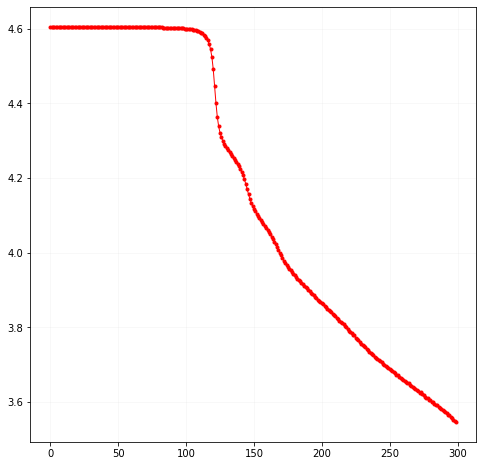

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), loss_data, lw=1, color='red', marker='.')
plt.grid(alpha=0.1)
plt.show()

In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# для инференса нам не требуется обновление весов, поэтому no_grad
with torch.no_grad():
    for data in test_loader:
        # запихиваем данные на device
        inputs, labels = data[0].to(device), data[1].to(device)

        # создаем вектор предсказаний
        outputs = net(inputs)
        _, predictions = torch.max(input=outputs, dim=1)

        # считаем количество угаданных и общее
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:>10} is {accuracy:.1f}%')

Accuracy for class:      apple is 37.0%
Accuracy for class: aquarium_fish is 22.0%
Accuracy for class:       baby is 14.0%
Accuracy for class:       bear is 7.0%
Accuracy for class:     beaver is 2.0%
Accuracy for class:        bed is 20.0%
Accuracy for class:        bee is 12.0%
Accuracy for class:     beetle is 22.0%
Accuracy for class:    bicycle is 22.0%
Accuracy for class:     bottle is 3.0%
Accuracy for class:       bowl is 0.0%
Accuracy for class:        boy is 4.0%
Accuracy for class:     bridge is 8.0%
Accuracy for class:        bus is 0.0%
Accuracy for class:  butterfly is 4.0%
Accuracy for class:      camel is 1.0%
Accuracy for class:        can is 0.0%
Accuracy for class:     castle is 21.0%
Accuracy for class: caterpillar is 23.0%
Accuracy for class:     cattle is 0.0%
Accuracy for class:      chair is 38.0%
Accuracy for class: chimpanzee is 37.0%
Accuracy for class:      clock is 2.0%
Accuracy for class:      cloud is 45.0%
Accuracy for class:  cockroach is 39.0%
Accuracy

p.s. В целях повышения образованности, сделаем numpy реализацию relu функций

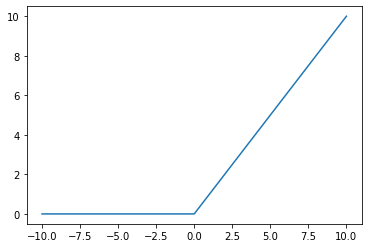

In [20]:
# вариант на numpy. Для работы с массивом используем функцию maximum
x = np.linspace(-10, 10, 1000)
y = np.maximum(0, x)
plt.plot(x, y);

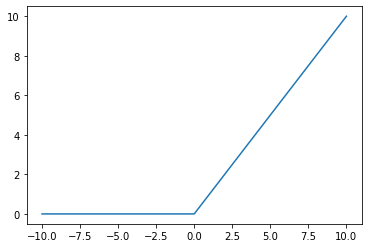

In [21]:
# Посмотрим на torch вариант. Не забываем перевести в тензор
y = F.relu(torch.Tensor(x))
plt.plot(x, y);

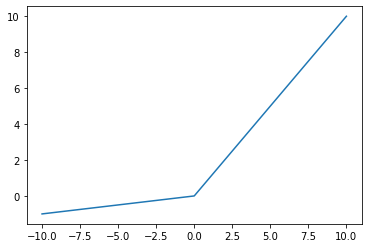

In [22]:
# Посмотрим, как выглядит leaky relu, то есть max(0.1x, x)
y = np.maximum(0.1 * x, x)
plt.plot(x, y);

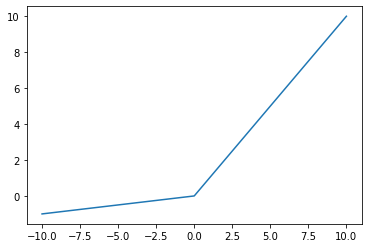

In [23]:
# Торчевый вариант
y = F.leaky_relu(torch.Tensor(x), 0.1)
plt.plot(x, y);

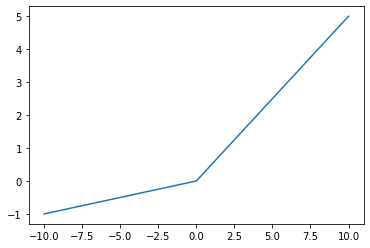

In [24]:
# И ограниченый leaky relu, или max(0.1x, 0.5x)
y = np.maximum(0.1 * x, 0.5 * x)
plt.plot(x, y);

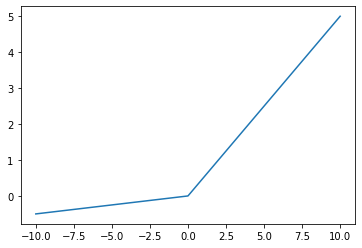

In [25]:
# Для подсчета в торче, умножим входной тензор на 0.5, а negative slope оставим как в обычном leaky relu
y = F.leaky_relu(0.5 * torch.Tensor(x), 0.1)
plt.plot(x, y);